In [1]:
#Import TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import KFold
import numpy as np 
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import sys
import foolbox, time

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB *  of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
#Load MNIST Dataset
#Quelle
#https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data, abgerufen 14.Juli 2021
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

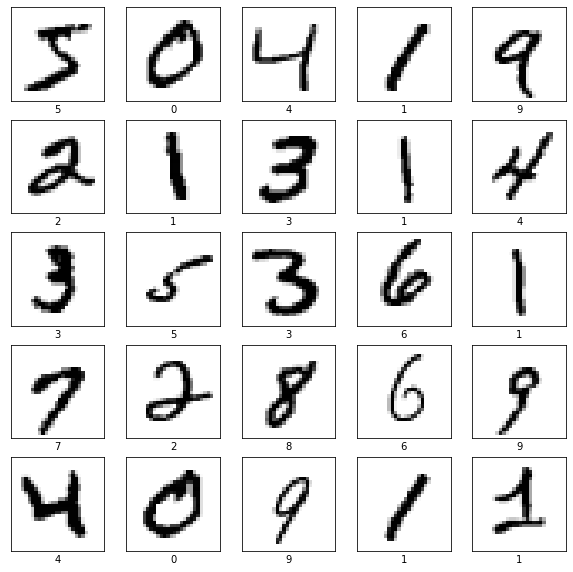

In [3]:
# Normalize pixel values to be between 0 and 1
x_train = x_train / 255.0 -0.5
x_test = x_test / 255.0 - 0.5

#Quelle
#https://matplotlib.org/stable/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py, abgerufen 14.Juli 2021

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

y_train = y_train.reshape(y_train.shape[0], 1)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

y_test = y_test.reshape(y_test.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

#inputs and targets for kFold training set
inputs = x_train
targets = y_train

In [10]:
#Quelle
#https://scikit-learn.org/stable/modules/cross_validation.html#k-fold, abgerufen 14.Juli 2021
num_folds = 10

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)


# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

    #Create and Train the Model for MNIST
    #Quelle
    #Architektur CNN: https://arxiv.org/pdf/1608.04644.pdf
    #https://www.tensorflow.org/guide/keras/sequential_model, abgerufen 14.Juli 2021
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),  
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),   
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), 
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.Flatten(),  
      tf.keras.layers.Dense(200,activation='relu'),
      tf.keras.layers.Dropout(rate=0.5),
      tf.keras.layers.Dense(200,activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
    ])
      
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, decay=1e-6, momentum=0.9, nesterov=True),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'],
    )

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    #model.summary()

    #Quelle
    #https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint, abgerufen 14.Juli 2021
    
    checkpoint_filepath = f'tmp/checkpoint{fold_no}'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    
    #Quelle
    #https://www.tensorflow.org/guide/keras/train_and_evaluate, abgerufen 14.Juli 2021
    
    history = model.fit(
        inputs[train], targets[train],
        epochs=50,
        batch_size=128,
        validation_data=(inputs[test], targets[test]),
        callbacks=[model_checkpoint_callback]
    )

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(model.metrics_names)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Save the entire model
    !mkdir -p saved_models_mnist_kfold
    model.save(f'saved_models_mnist_kfold/base_model_mnist_{fold_no}')
    
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
422/422 [==============================] - 3s 7ms/step - loss: 1.6541 - accuracy: 0.4162 - val_loss: 0.1431 - val_accuracy: 0.9540
Epoch 2/50
422/422 [==============================] - 3s 7ms/step - loss: 0.1535 - accuracy: 0.9556 - val_loss: 0.0653 - val_accuracy: 0.9800
Epoch 3/50
422/422 [==============================] - 3s 7ms/step - loss: 0.1096 - accuracy: 0.9683 - val_loss: 0.0547 - val_accuracy: 0.9850
Epoch 4/50
422/422 [==============================] - 3s 7ms/step - loss: 0.0875 - accuracy: 0.9754 - val_loss: 0.0371 - val_accuracy: 0.9892
Epoch 5/50
422/422 [==============================] - 3s 7ms/step - loss: 0.0747 - accuracy: 0.9789 - val_loss: 0.0532 - val_accuracy: 0.9843
Epoch 6/50
422/422 [==============================] - 3s 7ms/step - loss: 0.0634 - accuracy: 0.9814 - val_loss: 0.0584 - val_accuracy: 0.9828
Epoch 7/50
422/422 [==============================]

KeyboardInterrupt: 

In [ ]:
fig1, plotacc = plt.subplots()
plotacc.set_xlabel('CNN MNIST', rotation=90)
plotacc.set_ylabel('Training Accuracy in (%)')
print(acc_per_fold)
plt.show()

In [ ]:
#Quelle
#https://www.tensorflow.org/tutorials/images/transfer_learning, abgerufen 14.Juli 2021

def display_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title(title)

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title(title)
    plt.xlabel('epoch')
    plt.show()

In [ ]:
# Display training curve 
display_history(history, "CNN Base Model MNIST")

In [ ]:
y=model.predict(test_images)
print(np.argmax(y[1500]))
plt.imshow(test_images[1500], cmap=plt.cm.binary)

In [12]:
import pandas as pd
# Evaluate all 10 models
accuracy = list()
for i in range(1,11):
    model = tf.keras.models.load_model(f'saved_models_mnist_kfold/base_model_mnist_{i}')
    model.load_weights(f'tmp/checkpoint{i}')

    loss, acc = model.evaluate(x_test, y_test, verbose=2)
    print('Accuracy: {:5.2f}%'.format(100 * acc))
    accuracy.append(acc)
    print(model.predict(x_test).shape)
    
    df = pd.DataFrame(accuracy, columns=['Scores'])
    df.to_excel('accuracy.xlsx', sheet_name='kfold', index=False)

313/313 - 1s - loss: 0.0377 - accuracy: 0.9902
Accuracy: 99.02%
(10000, 10)
313/313 - 1s - loss: 0.0337 - accuracy: 0.9936
Accuracy: 99.36%
(10000, 10)
313/313 - 1s - loss: 0.0287 - accuracy: 0.9929
Accuracy: 99.29%
(10000, 10)
313/313 - 1s - loss: 0.0268 - accuracy: 0.9922
Accuracy: 99.22%
(10000, 10)
313/313 - 1s - loss: 0.0343 - accuracy: 0.9915
Accuracy: 99.15%
(10000, 10)
313/313 - 1s - loss: 0.0264 - accuracy: 0.9937
Accuracy: 99.37%
(10000, 10)
313/313 - 1s - loss: 0.0275 - accuracy: 0.9940
Accuracy: 99.40%
(10000, 10)
313/313 - 1s - loss: 0.0275 - accuracy: 0.9933
Accuracy: 99.33%
(10000, 10)
313/313 - 1s - loss: 0.0398 - accuracy: 0.9918
Accuracy: 99.18%
(10000, 10)
313/313 - 1s - loss: 0.0378 - accuracy: 0.9910
Accuracy: 99.10%
(10000, 10)


In [4]:
#Import Foolbox Packages
#Quelle
#https://foolbox.readthedocs.io/en/stable/, abgerufen 14.Juli 2021
from foolbox import TensorFlowModel, accuracy, samples, Model, utils, attacks, plot
from foolbox.attacks import LinfPGD, LinfDeepFoolAttack
import pandas as pd

In [5]:
model = tf.keras.models.load_model(f'saved_models_mnist_kfold/base_model_mnist_5')
model.load_weights(f'tmp/checkpoint5')

In [6]:
#Run an attack with foolbox
#Quelle
#https://github.com/bethgelab/foolbox, abgerufen 14.Juli 2021
preprocessing = dict()
bounds = (-0.5, 0.5)
fmodel = TensorFlowModel(model, bounds=bounds, preprocessing=preprocessing)
fmodel = fmodel.transform_bounds((-0.5, 0.5))

attack_labels = tf.convert_to_tensor(y_test, dtype='int64')
attack_labels = tf.reshape(attack_labels, 10000)
attack_images = tf.convert_to_tensor(x_test, dtype='float32')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [9]:
#Quelle
#https://www.kaggle.com/josephvm/generating-adversarial-examples-with-foolbox, abgerufen 14.Juli 2021
predictions = model.predict(attack_images)
orig_predictions = np.argmax(predictions, axis = 1)
print(f"Clean Accuracy:  {np.mean(orig_predictions == attack_labels) * 100:.2f} %") # Accuracy of original images
already_correct = np.sum(orig_predictions != attack_labels) # keep track of how many were already correct

Clean Accuracy:  99.15 %


In [10]:
#Quelle
#https://foolbox.jonasrauber.de/guide/examples.html, abgerufen 14.Juli 2021
#PGD40 mit 20 Restarts
import eagerpy as ep
attack_images = ep.astensor(attack_images)
attack_labels = ep.astensor(attack_labels)
attack = attacks.LinfPGD()
epsilons = [
        0.0,
        0.0002,
        0.0005,
        0.0008,
        0.001,
        0.0015,
        0.002,
        0.003,
        0.01,
        0.1,
        0.15,
        0.2,
        0.25,
        0.3,
        0.5,
        1.0,
    ]

success_rate = np.zeros(len(epsilons))

loop_array = np.array_split(np.arange(attack_images.shape[0]), 20)

for i , idx in enumerate(loop_array): 
    restarts = 20

    truth_array = np.zeros(shape=(len(epsilons),len(idx)), dtype=bool)
    print('Batch: ', i)
    for k in range(restarts):
        print('Restart: ', k)
        raw, clipped, is_adv = attack(fmodel, attack_images[idx], attack_labels[idx], epsilons=epsilons)
        arr = is_adv.numpy()
        truth_array = truth_array | arr
    
    success_rate += np.sum(truth_array, axis=1)
#print(attack_images.shape)
#print('Success Rate:', success_rate / attack_images.shape[0])
    
print("Attack finished!")
print('Success Rate:', success_rate / attack_images.shape[0])
df = pd.DataFrame((success_rate / attack_images.shape[0]), columns=['Success_rate'])
df.to_excel('attack_success_rate.xlsx', sheet_name='attack', index=False)

Batch:  0
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16
Restart:  17
Restart:  18
Restart:  19
Batch:  1
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16
Restart:  17
Restart:  18
Restart:  19
Batch:  2
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16
Restart:  17
Restart:  18
Restart:  19
Batch:  3
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16

In [ ]:
print('Versionsinformationen der Module:')
print(sys.executable)
print(sys.version)
print(sys.version_info)
!conda --version
!python --version
print('Tensorflow: ' + tf.__version__)
print('Tensorflow Datasets: ' + tfds.__version__)
print('Scikit Learn: ' + sklearn.__version__)
print('Eagerpy: ' + ep.__version__)
print('Numpy: ' + np.__version__)
print('Matplotlib: ' + matplotlib.__version__)
print('Foolbox: ' + foolbox.__version__)
print('Pandas: ' + pd.__version__)